<a href="https://colab.research.google.com/github/hsmai/winterurp/blob/main/BCI5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
  Attempting uninstall: pytest
    Found existi

In [20]:
import numpy as np
import mne
from moabb.datasets import Cho2017
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from mne.decoding import CSP
import matplotlib.pyplot as plt

In [24]:
dataset = Cho2017()
dataset.download(subject_list=[1])  # 1번 피험자만 다운로드


#paradigm=LeftRightImagery()
#x,y,z=paradigm.get_data(dataset=dataset, subjects=[1])
#x.shape, y.shape

paradigm = MotorImagery()
subjects = dataset.subject_list[:1]  # 첫 번째 피험자만 사용

X, labels, metadata = paradigm.get_data(dataset=dataset, subjects=subjects)
print(f"데이터 형태: {X.shape}, 라벨 개수: {len(set(labels))}")


/usr/local/lib/python3.11/dist-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 200 events (all good), 0 – 3 s (baseline off), ~150.2 MiB, data loaded,
 'left_hand': 100
 'right_hand': 100>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


데이터 형태: (200, 64, 1537), 라벨 개수: 2
X.shape: (200, 64, 1537)


In [44]:
montage = mne.channels.make_standard_montage("standard_1020")

n_channels = X.shape[1]

print(montage.ch_names)

std_1020_names = montage.ch_names[:n_channels]

info = mne.create_info(ch_names=std_1020_names, sfreq=250, ch_types="eeg")

raw = mne.io.RawArray(X[0], info)  # 첫 번째 시도(trial) 데이터 사용



raw.set_montage(montage)  # 전극 위치 설정

print(raw.info['dig'])  # None이 아니어야 함

print(raw.info)

['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', 'AF10', 'F9', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10', 'O1', 'Oz', 'O2', 'O9', 'Iz', 'O10', 'T3', 'T5', 'T4', 'T6', 'M1', 'M2', 'A1', 'A2']
Creating RawArray with float64 data, n_channels=64, n_times=1537
    Range : 0 ... 1536 =      0.000 ...     6.144 secs
Ready.
[<DigPoint |        LPA : (-82.5, -0.0, 0.0) mm     : head frame>, <DigPoint |     Nasion : (0.0, 114.0, 0.0) mm      : head frame>, <DigPoint |        RPA : (82.5, 0.0, -0.0) mm      : head frame>, <DigPoint |     EEG #1 : (-30.9, 114.6, 27.9) mm   : h

In [45]:
freq_bands = [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 36), (36, 40)]

In [46]:
def apply_fbcsp(X, y, freq_bands, sfreq=250, n_components=4):
    csp_features = []
    for fmin, fmax in freq_bands:
        # 대역 필터링
        band_filtered_X = mne.filter.filter_data(X, sfreq, fmin, fmax, fir_design='firwin')

        # CSP 적용
        csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
        csp_features.append(csp.fit_transform(band_filtered_X, y))

    # 모든 대역의 특징을 결합
    return np.concatenate(csp_features, axis=1)

# FBCSP 특징 추출
X_fbcsp = apply_fbcsp(X, labels, freq_bands)
print(f"FBCSP 특징 벡터 크기: {X_fbcsp.shape}")  # (Trials, Features)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 9.3e+03 (2.2e-16 eps * 64 dim * 6.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 3.7e+03 (2.2e-16 eps * 64 dim * 2.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.2s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 2e+03 (2.2e-16 eps * 64 dim * 1.4e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 207 samples (0.828 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 6.6e+02 (2.2e-16 eps * 64 dim * 4.7e+16  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 20 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 165 samples (0.660 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.1e+02 (2.2e-16 eps * 64 dim * 8e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 24 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.00
- Lower transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 21.00 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 139 samples (0.556 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 64 dim * 2.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 28 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 119 samples (0.476 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 64 dim * 1.5e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 32 - 36 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 32.00
- Lower transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 28.00 Hz)
- Upper passband edge: 36.00 Hz
- Upper transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 40.50 Hz)
- Filter length: 105 samples (0.420 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.0s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 64 dim * 9.1e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 36 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 36.00
- Lower transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 93 samples (0.372 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.0s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 64 dim * 1.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
FBCSP 특징 벡터 크기: (200, 36)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_fbcsp, labels, test_size=0.2, random_state=42)

In [48]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f"LDA 분류 정확도: {acc:.2f}")

LDA 분류 정확도: 0.97


In [56]:
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF9, AF7, AF5, AF3, AF1, AFz, AF2, AF4, AF6, AF8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    4.9s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 9.3e+03 (2.2e-16 eps * 64 dim * 6.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.6s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 3.7e+03 (2.2e-16 eps * 64 dim * 2.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.3s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 2e+03 (2.2e-16 eps * 64 dim * 1.4e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 207 samples (0.828 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.3s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 6.6e+02 (2.2e-16 eps * 64 dim * 4.7e+16  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 20 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 165 samples (0.660 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.2s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 1.1e+02 (2.2e-16 eps * 64 dim * 8e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 24 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.00
- Lower transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 21.00 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 139 samples (0.556 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 64 dim * 2.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 28 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 119 samples (0.476 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 64 dim * 1.5e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 32 - 36 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 32.00
- Lower transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 28.00 Hz)
- Upper passband edge: 36.00 Hz
- Upper transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 40.50 Hz)
- Filter length: 105 samples (0.420 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.0s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 64 dim * 9.1e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Setting up band-pass filter from 36 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 36.00
- Lower transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 93 samples (0.372 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.0s
[Parallel(n_job

Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 64 dim * 1.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.


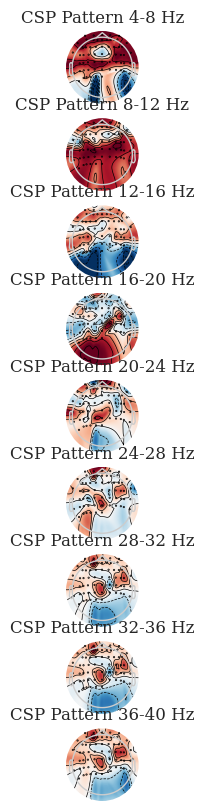

In [59]:
fig, axes = plt.subplots(len(freq_bands), 1, figsize=(8, 10))

for i, (fmin, fmax) in enumerate(freq_bands):
    axes[i].set_title(f"CSP Pattern {fmin}-{fmax} Hz")

    csp = CSP(n_components=4, log=True)
    csp.fit(mne.filter.filter_data(X, 250, fmin, fmax, fir_design='firwin'), labels)

    # raw.info 대신 info 사용 (전극 위치가 포함된 정보)

    mne.viz.plot_topomap(csp.patterns_[0], raw.info, axes=axes[i], show=False)

plt.show()

In [1]:
!git --version

git version 2.34.1


In [2]:
!git config --global user.name "hsmai"
!git config --global user.email "artcodehsm@gmail.com"

In [3]:
!git clone https://github.com/hsmai/winterurp

Cloning into 'winterurp'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 210 (delta 29), reused 40 (delta 10), pack-reused 143 (from 1)
Receiving objects: 100% (210/210), 24.79 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (68/68), done.
